## DCGAN

* [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) with Fashion MNIST data.
* First of all, you should import [GAN.py](https://github.com/tensorpack/tensorpack/blob/master/examples/GAN/GAN.py) at the same path.
* [Reference](https://github.com/tensorpack/tensorpack/blob/master/examples/GAN/DCGAN.py) 

In [1]:
import cv2  
import tensorflow as tf
import matplotlib.pyplot as plt

from GAN import *
from PIL import Image
from tensorpack import *
from tensorpack.dataflow import *
from tensorpack.callbacks import *
from tensorpack.tfutils import summary
from tensorpack.utils.viz import stack_patches
from tensorpack.tfutils.scope_utils import auto_reuse_variable_scope

### Dataflow

In [2]:
def get_dataflow(batch_size, is_train='train'):
    df = dataset.FashionMnist(is_train, shuffle=True)
    istrain = is_train == 'train'
    
    # ----- Image Augmentation Options -------- #
    if istrain:
        augs = [imgaug.Resize((64, 64))]
    else:
        augs = [
            #   imgaug.CenterCrop(256, 256),
            #   imgaug.Resize((225, 225)),
        ]
    df = AugmentImageComponent(df, augs)
    # group data into batches of size 128
    df = BatchData(df, batch_size)
    # start 5 processes to run the dataflow in parallel
    df = PrefetchDataZMQ(df, 5)
    return df

### Model   

In [3]:
class Model(GANModelDesc):
    def __init__(self, shape, batch, z_dim):
        self.shape = shape
        self.batch = batch
        self.zdim = z_dim
        self.gen_images = None

    def inputs(self):
        return [tf.placeholder(tf.float32, [None, self.shape, self.shape], 'input')]

    # genrator
    def generator(self, z):
        """return an image generated from z
        """
        l = FullyConnected('fc0', z, 1024 * 4 * 4, activation=tf.identity)
        l = tf.reshape(l, [-1, 4, 4, 1024])
        l = BNReLU(l)
        with argscope(Conv2DTranspose, activation=BNReLU, kernel_size=4, stride=2):
            g = (LinearWrap(l)
                 .Conv2DTranspose('deconv_0', 512)
                 .Conv2DTranspose('deconv_1', 256)
                 .Conv2DTranspose('deconv_2', 128)
                 .Conv2DTranspose('deconv_3', 1, activation=tf.identity)())    
            g = tf.tanh(g, name='gen')
        return g
                   
    # discriminator
    @auto_reuse_variable_scope
    def discriminator(self, imgs):
        with argscope(Conv2D, kernel_size=4, stride=2):
            d = (LinearWrap(imgs)
                 .Conv2D('conv0', 64, activation=tf.nn.leaky_relu)
                 .Conv2D('conv1', 128)
                 .BatchNorm('bn1')
                 .tf.nn.leaky_relu()
                 .Conv2D('conv2', 256)
                 .BatchNorm('bn2')
                 .tf.nn.leaky_relu()
                 .Conv2D('conv3', 512)
                 .BatchNorm('bn3')
                 .tf.nn.leaky_relu()
                 .FullyConnected('fc1', 1,
                                 activation=tf.identity)())                   
        return d
                 
    
    def build_graph(self, imgs):
        # NHW to NHWC
        imgs = tf.expand_dims(imgs, 3)
        
        z = tf.random_uniform([self.batch, self.zdim], -1, 1, name='z_train')
        z = tf.placeholder_with_default(z, [None, self.zdim], name='z')         
        
        with argscope([Conv2D, Conv2DTranspose, FullyConnected],
                      kernel_initializer=tf.truncated_normal_initializer(stddev=0.02)):
            with tf.variable_scope('gen'):
                gen_image = self.generator(z)
            tf.summary.image('Generated-Images', gen_image, max_outputs=25)

            with tf.variable_scope('discrim'):
                logits_real = self.discriminator(imgs)
                logits_fake = self.discriminator(gen_image)
                 
            self.build_losses(logits_real, logits_fake)
            self.collect_variables()
                 
    
    def optimizer(self):
        lr = tf.get_variable('learning_rate', initializer=2e-4, trainable=False)
        return tf.train.AdamOptimizer(lr, beta1=0.5, beta2 = 0.999, epsilon=1e-3)

### Main

In [ ]:
# dataset
df = get_dataflow(100, 'train')
steps_per_epoch = df.size()

model = Model(64, 100, 100)

# training with CPU or GPU?
if tf.test.gpu_device_name():c
    logger.set_logger_dir('./DCGAN_log')
    MultiGPUGANTrainer(num_gpu = 4,
                       input = QueueInput(df),
                       model = model).train_with_defaults(
                                          callbacks=[PeriodicTrigger(
                                                      ModelSaver(checkpoint_dir='./GAN_log'),
                                                      every_k_epochs=10)],
                                          steps_per_epoch = steps_per_epoch,
                                          max_epoch=100)
else:
    logger.set_logger_dir('./DCGAN_log')
    GANTrainer(input = QueueInput(df),
               model = model).train_with_defaults(
                                  callbacks=[PeriodicTrigger(
                                              ModelSaver(checkpoint_dir='./GAN_log'),
                                              every_k_epochs=10)],
                                  steps_per_epoch = steps_per_epoch,
                                  max_epoch=100)
    

### See the original images

[0822 07:28:18 @fs.py:100] WRN Env var $TENSORPACK_DATASET not set, using /root/tensorpack_data for datasets.
[0822 07:28:18 @parallel.py:291] [PrefetchDataZMQ] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[0822 07:28:18 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.
[0822 07:28:18 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.
[0822 07:28:18 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.
[0822 07:28:18 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.
[0822 07:28:18 @argtools.py:152] WRN Install python-prctl so that processes can be cleaned with guarantee.


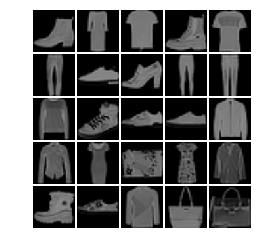

In [4]:
origin = get_dataflow(25, 'train')
origin.reset_state()

for idx, dp in enumerate(origin.get_data()):
    if idx == 0:
        dp = dp[0] + 1
        dp = dp * 90.0
        img = stack_patches(dp, nr_row=5, nr_col=5)  
        
        temp = img.reshape(332, 332)
        plt.axis('off')
        plt.imshow(temp, cmap='gray')
        break

### See the generated images

[0822 07:28:24 @varmanip.py:182] Checkpoint path ./DCGAN_log/model-60000.index is auto-corrected to ./DCGAN_log/model-60000.
[0822 07:28:24 @registry.py:121] gen/fc0 input: [None, 100]
[0822 07:28:24 @registry.py:129] gen/fc0 output: [None, 16384]
[0822 07:28:24 @registry.py:121] gen/deconv_0 input: [None, 4, 4, 1024]
[0822 07:28:24 @registry.py:129] gen/deconv_0 output: [None, 8, 8, 512]
[0822 07:28:24 @registry.py:121] gen/deconv_1 input: [None, 8, 8, 512]
[0822 07:28:24 @registry.py:129] gen/deconv_1 output: [None, 16, 16, 256]
[0822 07:28:24 @registry.py:121] gen/deconv_2 input: [None, 16, 16, 256]
[0822 07:28:24 @registry.py:129] gen/deconv_2 output: [None, 32, 32, 128]
[0822 07:28:24 @registry.py:121] gen/deconv_3 input: [None, 32, 32, 128]
[0822 07:28:24 @registry.py:129] gen/deconv_3 output: [None, 64, 64, 1]
[0822 07:28:24 @registry.py:121] discrim/conv0 input: [None, 64, 64, 1]
[0822 07:28:24 @registry.py:129] discrim/conv0 output: [None, 32, 32, 64]
[0822 07:28:24 @registry.

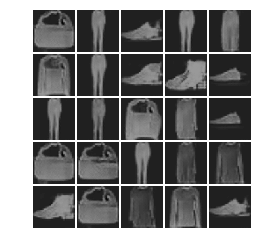

In [5]:
model = Model(64, 100, 100)

# loading the saved model.
session = get_model_loader('./DCGAN_log/model-60000.index')

pred_config = PredictConfig(
        model = model,
        session_init = session,
        input_names = ['z'],
        output_names = ['gen/gen', 'z']
    )

# make 25 images
pred = SimpleDatasetPredictor(pred_config, RandomZData((25, 100)))

for i, gen in enumerate(pred.get_result()):  
    gen = gen[0] + 1
    gen = gen * 90.0
    gen = np.clip(gen, 0, 255)
    gen = gen[:, :, :, ::-1]
    img = stack_patches(gen, nr_row=5, nr_col=5)
    
    temp = img.reshape(332, 332)
    plt.axis('off')
    plt.imshow(temp, cmap='gray')
    break